# Disseration Experiment 3g
# Generate SHAP XAI Output (Credit Card Fraud) 
# - Experiment January 6¶
Ciaran Finnegan January 2023

# Import Libraries + Custom Functions

## Import Libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
# Import libs
import numpy as np
import pandas as pd

# Import SHAP libraries
import shap

# Import Display libraries
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
import raiutils
from raiutils.exceptions import UserConfigValidationException

# Import libraries to build ANN model
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Import ML Workflow Libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample


# Classifier training (not used for explainability)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#Import libraries for explainer metrics
from sklearn.cluster import KMeans
from scipy.spatial import distance


# Additional display libraires
import contextlib
import os
import sys
from contextlib import contextmanager


# Libraries used in Experiment Creation of XL Output Metrics
import os
import time
import random
import openpyxl

2024-01-06 22:02:57.458563: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-06 22:02:57.460929: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-06 22:02:57.508925: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-06 22:02:57.509914: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-06 22:02:58.280769: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Custom Functions

Dataset Visualisations

In [3]:
%run ./DS_Visualisation_Functions.ipynb

Metrics

In [4]:
%run ./XAI_Metrics_Functions.ipynb

Function 'example_function' executed in 2.0003 seconds
Result: Result, Execution Time: 2.000328302383423 seconds


Model Evaluation Functions

In [5]:
%run ./DS_Model_Build_Evaluation_Functions.ipynb

Track Experiment Result Functions

In [6]:
%run ./XAI_Experiment_Functions.ipynb

# Load Model

A Neural Network Model has been created in another Kubeflow Notebook and is being used in all the XAI experiments

In [7]:
loaded_model = keras.models.load_model('ccfraud_model')  # If saved as SavedModel

In [8]:
X_test_loaded, y_test_loaded, X_train_loaded, df_downsampled_loaded, dfCatCols = load_CC_train_test_data()

In [9]:
X_train_loaded.head(1)

,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_OnL,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card Present,DvcPosEntryMode_E-Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y
0,2,2,0,5462,2,1,1,1,1,2,...,0,1,0,0,1,1,0,0,1,0


## Re-Display Model Peformance

For illustration, the evualtion metrics of the NN model will be repeated here.

### Tabular Data

In [10]:
scaler = StandardScaler()   
X_test_loaded_scaled = scaler.fit_transform(X_test_loaded)

In [11]:
y_pred_loaded = display_model_metrics_tabular(loaded_model, X_test_loaded_scaled, y_test_loaded)

42/42 [==============================] - 0s 1ms/step - loss: 0.3741 - accuracy: 0.8744


42/42 [==============================] - 0s 978us/step


Metric,Value
Accuracy,0.874429
ROC AUC Score,0.937547
Precision (Class 0),0.891680
Recall (Class 0),0.855422
F1-Score (Class 0),0.873174
Precision (Class 1),0.858198
Recall (Class 1),0.893846
F1-Score (Class 1),0.875659


Tablular Done!


### Confusion Matrix

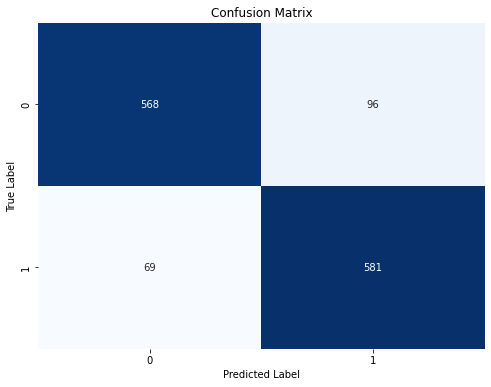

'Confusion Matrix!'

In [12]:
generate_confusion_matrix(y_test_loaded, y_pred_loaded)

-------------------------

# Generate Shap Values

## SHAP Summary Plot

In [13]:
# Create a SHAP explainer
# explainer = shap.KernelExplainer(model.predict, shap.sample(X_train_downsampled, 10)) #100

#Jan 6th - use new loaded model
explainer = shap.KernelExplainer(loaded_model.predict, shap.sample(X_train_loaded, 10)) #100

1/1 [==============================] - 0s 57ms/step


In [14]:
# Extract the feature names, excluding the target variable 'Fraud'
#column_names = df_downsampled.drop('default', axis=1).columns

#Jan 6th - use new loaded data
column_names = df_downsampled_loaded.drop('Fraud', axis=1).columns

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # Jan 6th - use new loaded test data, which is already a dataframe
    #shap_values = explainer.shap_values(X_test_downsampled.iloc[:5,:], silent=True) #100
    shap_values = explainer.shap_values(X_test_loaded.iloc[:10,:], silent=True) #100

680/680 [==============================] - 1s 979us/step


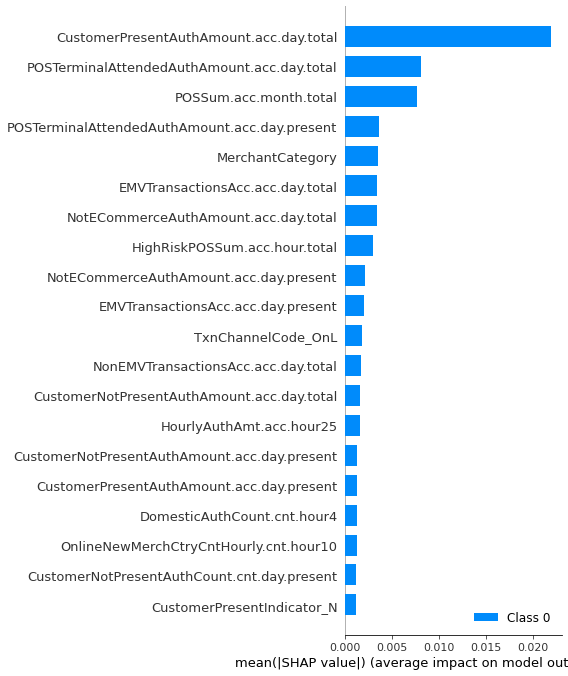

In [16]:
# Create a SHAP summary plot
#shap.summary_plot(shap_values, X_test_downsampled.iloc[:10,:], feature_names=X_train_downsampled.columns)

#Jan 6th - use new loaded data, which is already a dataframe
shap.summary_plot(shap_values, X_test_loaded.iloc[:10,:], feature_names=X_train_loaded.columns)

## Single Random Observation (for illustration)

In [17]:
# Select a random observation from the test dataset
#random_observation = X_test_downsampled.sample(1, random_state=42)

# Jan 6th - use loaded data
random_observation = X_test_loaded.sample(1, random_state=42)

In [18]:
# Generate SHAP values for the instances
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # Your code that produces warnings goes here
    shap_values_random_observation = explainer.shap_values(random_observation)

  0%|          | 0/1 [00:00<?, ?it/s]

680/680 [==============================] - 1s 962us/step


In [19]:
# Get the SHAP values for class 1 (default) for this observation
shap_values_observation_class1 = shap_values_random_observation[0]

In [20]:
# Convert SHAP values to a Series for easier manipulation
shap_values_series = pd.Series(shap_values_observation_class1[0], index=random_observation.columns)

In [21]:
# Sort the features based on absolute SHAP value
sorted_features = shap_values_series.abs().sort_values(ascending=False)

In [22]:
# Display the top 20 features for the random observation in an aesthetically pleasing tabular format
top_20_features_observation = sorted_features.head(20)
top_20_features_df_observation = pd.DataFrame({'Feature': top_20_features_observation.index, 
                                               'SHAP Value': top_20_features_observation.values})

In [23]:
# Display the index (row number) of the selected observation
print(f"Selected Row Number from Test Data: {random_observation.index[0]}")

Selected Row Number from Test Data: 1232


In [24]:
# Display the SHAP values for the top 20 features of the observation
print("\nTop 20 Features and Their SHAP Values:")
display(HTML(xai_styles + top_20_features_df_observation.to_html(index=False)))


Top 20 Features and Their SHAP Values:


Feature,SHAP Value
CustomerPresentAuthAmount.acc.day.total,0.001541
CustomerPresentAuthAmount.acc.day.present,0.001114
NewMerchantCountryCount.cnt.hour24,0.001035
POSTerminalAttendedAuthAmount.acc.day.present,0.001012
PosTerminalAttended_U,0.000953
POSSum.acc.month.total,0.000771
ECommerceAuthCount.cnt.day.present,0.000738
DvcPosEntryMode_E-Commerce,0.000722
DvcPosEntryMode_U,0.000721
DomesticAuthCounter.cnt.day.present,0.000689


## Prepare SHAP Values Data for Metric Calculations

Use a custom built decorator to track the time taken to generate the SHAP values

In [25]:
@timeit
def generate_shap_explanations(model, data, target_column='Fraud', 
                                output_instance_file='instances2.csv', 
                                output_shap_file='shap_values2.csv'):
    # Drop the target column from the data
    data_features = data.drop(columns=[target_column])
    
    # Select a subset of the data for explanation (first 60 instances)
    instances_to_explain = data_features.iloc[:60, :]#25
    
    # Create a SHAP explainer
    explainer = shap.KernelExplainer(model.predict, shap.sample(data_features, 100)) #100
    
    # Generate SHAP values for the instances
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        # Your code that produces warnings goes here
        shap_values = explainer.shap_values(instances_to_explain)
    
    # Convert the SHAP values to a DataFrame
    if isinstance(shap_values, list):
        # For multi-class models, average the SHAP values over all classes
        shap_values = np.mean(shap_values, axis=0)
    df_shap_values = pd.DataFrame(shap_values, columns=data_features.columns)
    
    
    
    
    # Jan 6th - align index of instances df to the newly created shap values
    # Reindex df1 to the index of df2
    #df_instances_to_explain_reindexed = instances_to_explain.reindex(df_shap_values.index)
    instances_to_explain = instances_to_explain.reset_index(drop=True)
    df_shap_values = df_shap_values.reset_index(drop=True)



    
    # Output the SHAP values to a csv file
    df_shap_values.to_csv(output_shap_file, index=False)
    
    # Output the instances to a csv file
    instances_to_explain.to_csv(output_instance_file, index=False)
    
    return instances_to_explain, df_shap_values

# Generate XAI Metrics 

## Identity

#### Retrieve Identity Score

In [26]:
#from scipy.spatial import distance
#SHAP_Identity_Metric = get_identity_metric(df_instances, df_shap_values, "SHAP")

#### Display Identity Score Metric

In [27]:
#SHAP_Identity_Number = "{:.2f}%".format(SHAP_Identity_Metric)
#display_text("SHAP Identity Metric Score: " + SHAP_Identity_Number)

## Stability

#### Retrieve Stability Score

In [28]:
# Jan 6th - use loaded data
#SHAP_Stability_Metric = get_stability_metric_y(df_shap_values, y_test_loaded, 'SHAP')

#### Display Stability Score Metric

In [29]:
#SHAP_Stability_Number = "{:.2f}%".format(SHAP_Stability_Metric)
#display_text("SHAP Stability Metric Score: " + SHAP_Stability_Number)

## Seperability

#### Retrieve Seperability Score

In [30]:
#SHAP_Seperability_Metric = get_seperability_metric(df_instances, df_shap_values, "SHAP")

#### Display Seperability Score Metric

In [31]:
#SHAP_Seperability_Number = "{:.2f}%".format(SHAP_Seperability_Metric)
#display_text("SHAP Seperability Metric Score: " + SHAP_Seperability_Number)

## Similarity

#### Retrieve Similarity Score

In [32]:
#SHAP_Similarity_Metric = get_similarity_metric(df_instances, df_shap_values, "SHAP", use_dbscan=False)

#### Display Similarity Score Metric

In [33]:
#SHAP_Similarity_Number = "{:6.2f}".format(SHAP_Similarity_Metric)
#display_text("SHAP Similarity Metric Value: " + SHAP_Similarity_Number)

# XAI Experiments - Metrics Capture

## Suppress Warnings to clean up output

In [34]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

## Break out Model Test Data into a list of dataframes

### Create Test Data for Experiment Input

Ensure 'X_test' and 'y_test' Are DataFrames with Proper Columns

In [35]:
# Assuming 'X_test' is a numpy array and you have a list of the original column names
original_feature_names = [col for col in df_downsampled_loaded.columns if col != 'Fraud']

# Ensure X_test_loaded has the correct column names (if necessary)
X_test_loaded.columns = original_feature_names

In [36]:
# Combine X_test_loaded and y_test into a single DataFrame
df_TestData = pd.concat([X_test_loaded, y_test_loaded], axis=1)

### Split the DataFrame into 20 consecutive smaller DataFrames

In [37]:
# Split the DataFrame into 20 consecutive smaller DataFrames
split_size, list_df = split_TestData_into_nn_Blocks(df_TestData, num_splits = 20)

Original DF Length: 1314
Split Size: 65


In [38]:
# Count the occurrence of each unique value in the 'Fraud' column
fraud_counts = df_TestData['Fraud'].value_counts()

# Display the counts
print("Breakdown of 'Fraud' and non-Fraud label records in df_TestData:")
print(fraud_counts)

Breakdown of 'Fraud' and non-Fraud label records in df_TestData:
0    664
1    650
Name: Fraud, dtype: int64


### Add a routine to check output values

In [39]:
# Display starting points in the first nn sub dataframes
startBlockDisplay(df_TestData, split_size, 1)

,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card Present,DvcPosEntryMode_E-Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y,Fraud
0,1,0,1,5541,1,0,1,1,1,1,...,1,0,0,1,1,0,0,1,0,1


## Confirm Starting Point in External SHAP XAI XL File

The code below acts so that for each dataframe in the list just created the following actions are carried out;

Check if an XAI results XL spreadsheet called 'SHAP_XAI_Metrics_Experiments.xls' exists;

If not create an empty XL spreadsheet with the name 'SHAP_XAI_Metrics_Experiments.xls', and then define a variable called ‘Sample’ with an integer value of 1 and print the value of 'Sample' to output.

If and XL spreadsheet called 'SHAP_XAI_Metrics_Experiments.xls' does exist, then read the entries in the spreadsheet in the first column named ‘Sample Number’ and create a variable in this Python program named ‘Sample’ that is one integer value higher than the highest integer number column named ‘Sample Number’ in the XL, and print this value of 'Sample' to output.

In [40]:
# Create a sequential number as an identifier for each DataFrame
list_df = {f'df_{i + 1}': list_df[i] for i in range(len(list_df))}

In [41]:
# File path for the SHAP XAI metrics results spreadsheet
SHAP_xai_file_path = 'SHAP_XAI_Metrics_Experiments.xlsx'  # Stored locally

In [42]:
# Call Function to update or create the spreadsheet and determine the 'Sample' number
# Process each dataframe in 'list_df'
sample = return_next_sample_number_to_process(list_df, SHAP_xai_file_path, "SHAP")

Sample Number for current SHAP XAI DataFrame: 11


## Select Next Dataframe to Process

---------------------------------

	
Extend the Python code so that the code reads in the dataframe from 'list df' that corresponds to the integer value in the 
variable named ‘Sample’. 

Assign this dataframe the name 'df_Selected_from_List'.


----------------------------------

### Initialize Dataframe to Capture Re-start Point as None

In [43]:
# Initialize df_Selected_from_List as None
df_Selected_from_List = None

### Extract test data block to restart XAI metrics process

In [44]:
df_Selected_from_List, key = select_restart_testdata_block(df_Selected_from_List, 
                                                           list_df, 
                                                           SHAP_xai_file_path)

DataFrame selected for Sample Number 11 witk key df_11


In [45]:
# If no DataFrame is selected (e.g., if 'Sample' exceeds the number of DataFrames in list_df)
if 'df_Selected_from_List' not in locals():
    print("No DataFrame selected. The 'Sample' number may exceed the number of DataFrames in list_df.")

---------------------------

## Generate XAI Metrics from Dataframe

### Generate the SHAP Values for the Test Data Block

In [46]:
df_Selected_from_List.head(2)

,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card Present,DvcPosEntryMode_E-Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y,Fraud
650,-4,0,4,7523,0,0,3,4,4,4,...,0,0,1,0,0,1,0,0,1,0
651,-4,0,4,7994,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,1


In [47]:
print(df_Selected_from_List.index)

RangeIndex(start=650, stop=715, step=1)


In [48]:
# Jan 6th - use loaded data
results_SHAP, exec_time_SHAP = generate_shap_explanations(loaded_model, df_Selected_from_List)

3/3 [==============================] - 0s 2ms/step


  0%|          | 0/60 [00:00<?, ?it/s]

4420/4420 [==============================] - 5s 1ms/step
Function 'generate_shap_explanations' executed in 368.4022 seconds


In [49]:
# Unpack the results to get df_instances_SHAP and df_shap_values
df_instances_SHAP, df_shap_values = results_SHAP

---------------------------

### Generate Identity Metric

#### Run a Basic Test First

In [50]:
# Select two random instances from the SHAP value dataframe
df_xai_numerical = df_shap_values

random_indices = np.random.choice(df_xai_numerical.index, size=2, replace=False)
instance_1 = df_xai_numerical.iloc[random_indices[0]]
instance_2 = df_xai_numerical.iloc[random_indices[1]]

# Compute the Euclidean distance between the selected instances - uses custom project function
distance = get_euclidean_distance(instance_1, instance_2)
print(f"Euclidean distance between instance {random_indices[0]} and instance {random_indices[1]}: {distance:.4f}")


Calculating Euclidean distance...


Euclidean distance between instance 9 and instance 8: 0.0055


#### Retrieve Identity Score

In [51]:
df_instances_SHAP.head(2)

,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_OnL,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card Present,DvcPosEntryMode_E-Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y
0,-4,0,4,7523,0,0,3,4,4,4,...,1,0,0,1,0,0,1,0,0,1
1,-4,0,4,7994,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,1,0


In [52]:
print(df_instances_SHAP.index)

RangeIndex(start=0, stop=60, step=1)


In [53]:
df_shap_values.head(2)

,OnlinePOSCount.cnt.day.present,EMVTransactionsCount.cnt.day.present,NonEMVTransactionsCount.cnt.day.present,MerchantCategory,POS_Count.cnt.day.present,PinIndicator,DomesticAuthCount.cnt.hour1,DomesticAuthCount.cnt.hour3,DomesticAuthCount.cnt.hour4,DomesticAuthCount.cnt.hour10,...,TxnChannelCode_OnL,TxnChannelCode_POS,CustomerPresentIndicator_N,CustomerPresentIndicator_U,CustomerPresentIndicator_Y,DvcPosEntryMode_Card Present,DvcPosEntryMode_E-Commerce,DvcPosEntryMode_U,ECommerceFlag_U,ECommerceFlag_Y
0,-0.000195,0.0,0.0,-0.001846,0.0,0.000000,0.0,-0.000214,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,-0.005502,0.0,-0.000422,0.0,0.000274,0.0,0.0,...,0.0,0.0,-0.000303,0.000592,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
print(df_shap_values.index)

RangeIndex(start=0, stop=60, step=1)


In [55]:
from scipy.spatial import distance
SHAP_Identity_Metric = get_identity_metric(df_instances_SHAP, df_shap_values, "SHAP")

Instance 0:   Current matches: 1
	Closest feature instance: 4 (Distance: 1915.0060)
	Closest SHAP instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 1:   Current matches: 1
	Closest feature instance: 3 (Distance: 239.4577)
	Closest SHAP instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 2:   Current matches: 1
	Closest feature instance: 9 (Distance: 559.8285)
	Closest SHAP instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 3:   Current matches: 1
	Closest feature instance: 1 (Distance: 239.4577)
	Closest SHAP instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 4:   Current matches: 2
	Closest feature instance: 0 (Distance: 1915.0060)
	Closest SHAP instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 5:   Current matches: 2
	Closest feature instance: 42 (Distance: 3184.1058)
	Closest SHAP instance: {closest_xai_idx} (

#### Display Identity Score Metric

In [56]:
SHAP_Identity_Number = "{:.2f}%".format(SHAP_Identity_Metric)
display_text("SHAP Identity Metric Score: " + SHAP_Identity_Number)

In [57]:
# Read in XAI Metric for Identity
XAI_Ident_Metric_1 = SHAP_Identity_Metric

---------------------------

### Generate Stability Metric

#### Retrieve Stability Score

In [58]:
# Jan 6th - use loaded data
SHAP_Stability_Metric = get_stability_metric_y(df_shap_values, y_test_loaded, 'SHAP')

Number of Instances in Cluster '0': 0
Number of Instances in Cluster '1': 0

For Class '0':
Total Instances: 29
Matching Cluster '0' Instances: 0

For Class '1':
Total Instances: 31
Matching Cluster '1' Instances: 0


This is the function in XAI_METRICS_FUNCTIONS -- STABILITY -- SHAP



Percentage of matches: 0.00%   0.0 Matches of 60 Entries


#### Display Stability Score Metric

In [59]:
SHAP_Stability_Number = "{:.2f}%".format(SHAP_Stability_Metric)
display_text("SHAP Stability Metric Score: " + SHAP_Stability_Number)

In [60]:
# Read in XAI Metric for Stability
XAI_Stability_Metric_2 = SHAP_Stability_Metric

----------------

### Generate Seperability Metric

#### Retrieve Seperability Score

In [61]:
SHAP_Seperability_Metric = get_seperability_metric(df_instances_SHAP, df_shap_values, "SHAP")

#### Display Seperability Score Metric

In [62]:
SHAP_Seperability_Number = "{:.2f}%".format(SHAP_Seperability_Metric)
display_text("SHAP Seperability Metric Score: " + SHAP_Seperability_Number)

In [63]:
# Read in XAI Metric for Seperability
XAI_Seperability_Metric_3 = SHAP_Seperability_Metric

----------------------------------

### Generate Similarity Metric

#### Retrieve Similarity Score

In [64]:
SHAP_Similarity_Metric = get_similarity_metric(df_instances_SHAP, df_shap_values, "SHAP", use_dbscan=False)

#### Display Similarity Score Metric

In [65]:
SHAP_Similarity_Number = "{:6.2f}".format(SHAP_Similarity_Metric)
display_text("SHAP Similarity Metric Value: " + SHAP_Similarity_Number)

In [66]:
# Read in XAI Metric for Similarity
XAI_Similarity_Metric_4 = SHAP_Similarity_Metric

-------------------

### Display Final Set of Metrics (this run)

In [67]:
# Print the results
print(f"XAI Ident Metric 1: {XAI_Ident_Metric_1}")
print(f"XAI Stability Metric 2: {XAI_Stability_Metric_2}")
print(f"XAI Seperability Metric 1: {XAI_Seperability_Metric_3}")
print(f"XAI Similarity Metric 1: {XAI_Similarity_Metric_4}")
print(f"XAI Time Metric 5: {exec_time_SHAP} seconds")

XAI Ident Metric 1: 31.666666666666664
XAI Stability Metric 2: 0.0
XAI Seperability Metric 1: 100.0
XAI Similarity Metric 1: 0.06589559427653627
XAI Time Metric 5: 368.402184009552 seconds


-------------------

## Write Out Metrics to XL

In [68]:
write_xai_Metrics_to_XL(SHAP_xai_file_path, 
                        sample, 
                        SHAP_Identity_Metric, 
                        SHAP_Stability_Metric, 
                        SHAP_Seperability_Metric, 
                        SHAP_Similarity_Metric, 
                        exec_time_SHAP, 
                        df_Selected_from_List,
                        "SHAP")

SHAP DataFrame selected for Sample Number 11 witk key df_11
